Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'


In [2]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
import matplotlib.pyplot as plt


## Use scikit-learn for hyperparameter optimization with RandomizedSearchCV

In [4]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    
    # return the wrangled dataframe
    return X

In [5]:
train = wrangle(train)
test = wrangle(test)


In [6]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality.index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [7]:
def reduce_cardinality_to_top_ten(feature, train, test):
    
    # Get a list of the top 10 entries in feature of interest
    top10 = train[feature].value_counts()[:10].index
    
    train = train.copy()
    test = test.copy()
    
    # At locations where the feature entry is NOT in the top 10,
    # replace the entry with 'OTHER'
    train.loc[~train[feature].isin(top10), feature] = 'OTHER'
    test.loc[~test[feature].isin(top10), feature] = 'OTHER'
    
    return train, test

In [8]:
categorical_features_with_more_than_ten_categories = []
for feature in categorical_features:
    if len(train[feature].unique()) > 10:
           categorical_features_with_more_than_ten_categories.append(feature)
            
categorical_features_with_more_than_ten_categories

['funder',
 'installer',
 'wpt_name',
 'subvillage',
 'region',
 'lga',
 'ward',
 'scheme_management',
 'scheme_name',
 'extraction_type',
 'extraction_type_group',
 'management']

In [9]:
for feature in categorical_features_with_more_than_ten_categories:
    train, test = reduce_cardinality_to_top_ten(feature, train, test)

In [10]:
X_train = train[features]
X_test = test[features]

y_train = train[target]


In [11]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score


In [13]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'MAE for {k} folds:', scores)

MAE for 3 folds: [0.80348485 0.80373737 0.80080808]


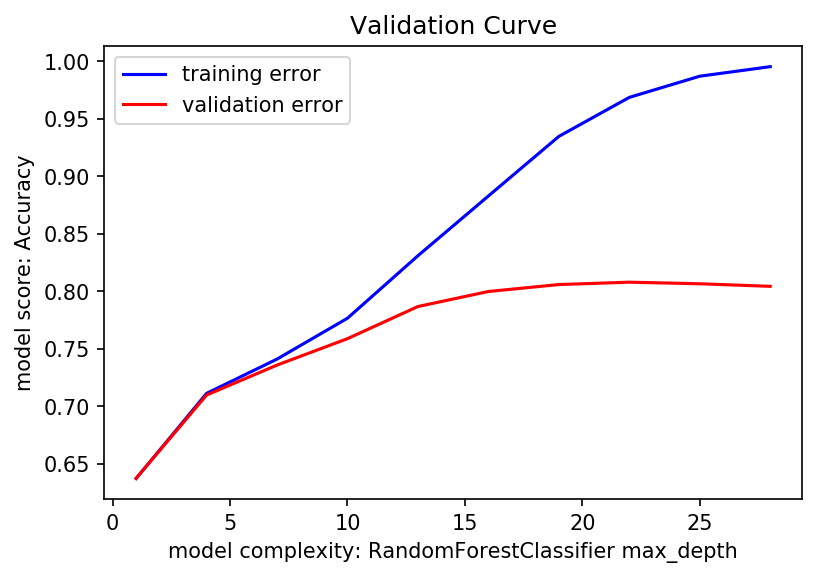

In [32]:


depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestclassifier__max_depth', 
    param_range=depth, scoring='accuracy', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier max_depth')
plt.ylabel('model score: Accuracy')
plt.legend()
#plt.ylim((.75, .85))
plt.show()

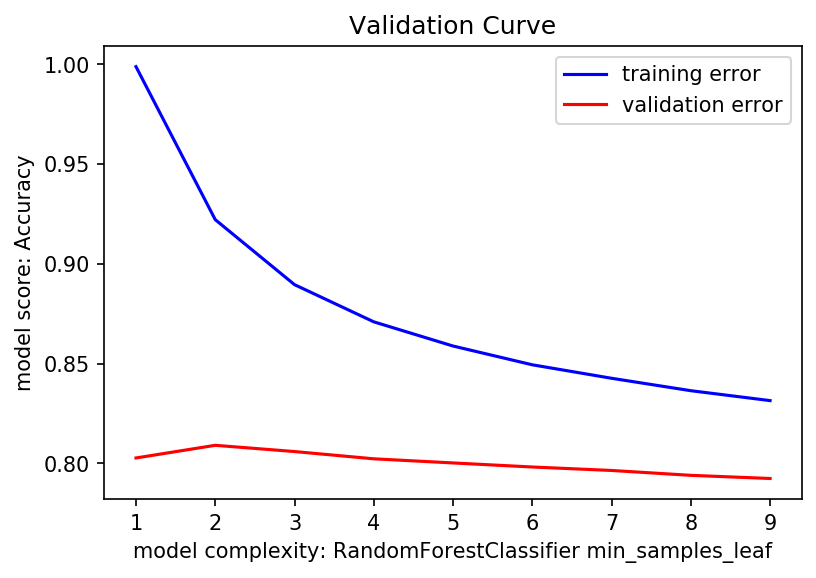

In [37]:


depth = range(1, 10, 1)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestclassifier__min_samples_leaf', 
    param_range=depth, scoring='accuracy', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier min_samples_leaf')
plt.ylabel('model score: Accuracy')
plt.legend()
#plt.xlim((4,5))
plt.show()

/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


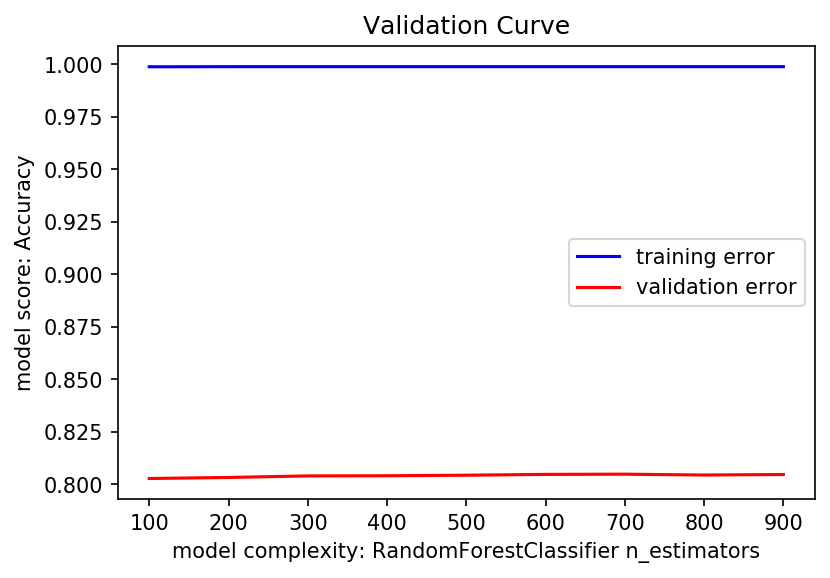

In [38]:


depth = range(100, 1000, 100)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestclassifier__n_estimators', 
    param_range=depth, scoring='accuracy', 
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier n_estimators')
plt.ylabel('model score: Accuracy')
plt.legend()
#plt.xlim((4,5))
plt.show()

In [40]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform


In [43]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8)
)

param_distributions = {
    'randomforestclassifier__min_samples_leaf': randint(1, 1000),  
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, 30, 35, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=30, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed: 10.9min remaining:   38.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.1min finished


Best hyperparameters {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.668819157886731, 'randomforestclassifier__min_samples_leaf': 20, 'randomforestclassifier__n_estimators': 370, 'simpleimputer__strategy': 'mean'}
Cross-validation MAE -0.7877104377104377


In [50]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8, max_depth=None, max_features= 0.668819157886731, min_samples_leaf=20, n_estimators=370, n_jobs=-1))
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))


0.8255892255892255


In [51]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('/home/alex/code/DS-Unit-2-Kaggle-Challenge/module3-cross-validation/alex-pakalniskis-kaggle-submission-day-3.1.csv', index=False)

# Best Submission

In [52]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8, max_depth=None, max_features= 0.668819157886731, min_samples_leaf=2, n_estimators=370, n_jobs=-1))
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))


0.9602693602693603


In [53]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('/home/alex/code/DS-Unit-2-Kaggle-Challenge/module3-cross-validation/alex-pakalniskis-kaggle-submission-day-3.2.csv', index=False)

In [16]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8,max_features= 0.668819157886731, min_samples_leaf=2, n_jobs=-1))
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))


0.9596632996632997


In [18]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('/home/alex/code/DS-Unit-2-Kaggle-Challenge/module3-cross-validation/alex-pakalniskis-kaggle-submission-day-3.6.csv', index=False)

In [54]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8, max_depth=32, max_features= 0.668819157886731, min_samples_leaf=2, n_estimators=370, n_jobs=-1))
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))


0.9590909090909091


In [55]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('/home/alex/code/DS-Unit-2-Kaggle-Challenge/module3-cross-validation/alex-pakalniskis-kaggle-submission-day-3.3.csv', index=False)

In [56]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8, max_depth=None, max_features= 0.668819157886731, min_samples_leaf=2, n_estimators=1000, n_jobs=-1))
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))


0.9606902356902357


In [57]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('/home/alex/code/DS-Unit-2-Kaggle-Challenge/module3-cross-validation/alex-pakalniskis-kaggle-submission-day-3.4.csv', index=False)